# Introduction to Machine Learning
# Analysis of Cheese Dataset
Author: Audrey Warner

# Introduction

This analysis will explore whether different characteristics of a cheese can predict its fat level. This is an interesting question to explore because it could provide information useful to cheesemakers, industry professionals and health-conscious consumers. Can we use this dataset to classify it as either high fat or low fat? 

For this machine learning analysis, classification will be used to determine whether we can use our dataset to predict a cheese's categorical fat level.  

# Exploratory Data Analysis 

First, we will import the libraries required for this analysis.

In [1]:
from hashlib import sha1

import altair as alt
import graphviz
import numpy as np
import pandas as pd
import string
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import (
    FunctionTransformer,
    Normalizer,
    OneHotEncoder,
    StandardScaler,
    normalize,
    scale)
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.svm import SVC, SVR

#alt.renderers.enable('mimetype')
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

Next, we will read in the data, and drop columns that are not relevant to the analysis, according to the project rubric.

In [2]:
cheese_df = pd.read_csv('cheese_data.csv').drop(columns=['CheeseId', 'FlavourEn','CharacteristicsEn', 'RindTypeEn', 'CheeseName'])
cheese_df.head()

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,FatLevel
0,NB,Farmstead,47.0,0,Firm Cheese,Ewe,Raw Milk,lower fat
1,NB,Farmstead,47.9,0,Semi-soft Cheese,Cow,Raw Milk,lower fat
2,ON,Industrial,54.0,0,Firm Cheese,Cow,Pasteurized,lower fat
3,NB,Farmstead,47.0,0,Veined Cheeses,Cow,Raw Milk,lower fat
4,NB,Farmstead,49.4,1,Semi-soft Cheese,Cow,Raw Milk,lower fat


**Table 1.** Relevant columns of the cheese dataframe

The following columns are the relevant features of this analysis:

* `ManufacturerProvCode` : The province in which a cheese was manufactured.
* `ManufacturingTypeEn` : The way a cheese was manufactured (farmstead or industrial).
* `MoisturePercent` : The amount of moisture in a cheese (%).
* `Organic` : Whether a cheese is organic (1) or not organic (0).
* `CategoryTypeEn` : The category each cheese falls into (Firm, Semi-soft, Veined).
* `MilkType` : The type of milk a cheese is made from (Cow, Goat, Ewe).
* `MilkTreatmentType` : How the milk was treated before a cheese was made (Pasteurized or Raw).

In this analysis, our target is the `FatLevel` column. To make analysis easier, we will convert lower fat to 0 and higher fat to 1. 

In [3]:
cheese_df['FatLevel'] = cheese_df['FatLevel'].replace(['lower fat'], 0)
cheese_df['FatLevel'] = cheese_df['FatLevel'].replace(['higher fat'], 1)
cheese_df.head()

,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,FatLevel
0,NB,Farmstead,47.0,0,Firm Cheese,Ewe,Raw Milk,0
1,NB,Farmstead,47.9,0,Semi-soft Cheese,Cow,Raw Milk,0
2,ON,Industrial,54.0,0,Firm Cheese,Cow,Pasteurized,0
3,NB,Farmstead,47.0,0,Veined Cheeses,Cow,Raw Milk,0
4,NB,Farmstead,49.4,1,Semi-soft Cheese,Cow,Raw Milk,0


**Table 2.** Modified cheese dataframe.

The next step is to split our cheese dataframe into train and test sets.

In [4]:
cheese_train, cheese_test = train_test_split(cheese_df, test_size = 0.2, random_state = 77)

We can determine the dtype of each column and whether it has any null values using `.info()`.

In [5]:
cheese_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ManufacturerProvCode  1042 non-null   object 
 1   ManufacturingTypeEn   1042 non-null   object 
 2   MoisturePercent       1028 non-null   float64
 3   Organic               1042 non-null   int64  
 4   CategoryTypeEn        1019 non-null   object 
 5   MilkTypeEn            1041 non-null   object 
 6   MilkTreatmentTypeEn   977 non-null    object 
 7   FatLevel              1042 non-null   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 65.2+ KB


There are null values in the following columns, which will be addressed using `SimpleImputer()`: 

* MoisturePercent
* CategoryTypeEn 
* MilkTypeEn
* MilkTreatmentTypeEn

Using the train dataset, we can determine summary statistics for the numeric `MoisturePercent` column. 

In [6]:
summary_stats = cheese_train.describe().drop(columns='Organic')
summary_stats

,MoisturePercent,FatLevel
count,823.000000,833.000000
mean,46.955043,0.344538
std,9.557279,0.475503
min,12.000000,0.000000
25%,40.000000,0.000000
50%,46.000000,0.000000
75%,52.000000,1.000000
max,88.000000,1.000000


**Table 3.** Summary statistics of the training set.

By creating a visualization of our data, we see that higher-fat cheeses have a lower average moisture percent than lower-fat cheeses.

In [7]:
cheese_plot = alt.Chart(cheese_train, width=200, height=300).mark_bar().encode(
    x='FatLevel',
    y='MoisturePercent'
    ).properties(title="Plot of Moisture Percent vs. Fat Level in Cheese")
cheese_plot

alt.Chart(...)

**Figure 1.** Plot of Moisture Percent vs. Fat Level of the training set.

Another interesting visualization within the high fat and low fat categories comes from plotting the milk type vs moisture percent.

We see that within the high fat cheese category, Ewe and Goat's milk cheeses have the highest moisture percent, but within the low fat cheese category, Cow's milk cheese has the highest moisture percent.   

In [8]:
high_fat = cheese_train.loc[cheese_train['FatLevel'] == 1]
low_fat = cheese_train.loc[cheese_train['FatLevel'] == 0]

In [9]:
high_fat_plot = alt.Chart(high_fat, width=500, height=300).mark_bar().encode(
    x='MilkTypeEn',
    y='MoisturePercent'
    ).properties(title="Plot of Moisture Percent vs. Milk Type for High-Fat Cheeses")
high_fat_plot

alt.Chart(...)

**Figure 2.** Plot of Moisture Percent vs. Milk Type for higher fat cheeses of the training set.

In [10]:
low_fat_plot = alt.Chart(low_fat, width=500, height=300).mark_bar().encode(
    x='MilkTypeEn',
    y='MoisturePercent'
    ).properties(title="Plot of Moisture Percent vs. Milk Type for Low-Fat Cheeses")
low_fat_plot

alt.Chart(...)

**Figure 3.** Plot of Moisture Percent vs. Milk Type for lower fat cheeses of the training set.

The next step of this exploratory analysis is to determine the distribution of the target column using `value_counts()`.

In [11]:
cheese_train['FatLevel'].value_counts()

0    546
1    287
Name: FatLevel, dtype: int64

In [12]:
low_fat = print(546/(546+287))

0.6554621848739496


In [13]:
high_fat = print(287/(546+287))

0.3445378151260504


We can see that there are more low fat cheeses than high fat cheeses in our training set, however the data is relatively balanced so we will not need to use the `class_weight` argument in our estimator. 

# Methods and Results 

## 1. Preprocessing and Building Pipelines

We first create our training and test sets, knowing that the `FatLevel` column is our target. 

In [14]:
X_train = cheese_train.drop(columns=['FatLevel'])
y_train = cheese_train['FatLevel']
X_test = cheese_test.drop(columns=['FatLevel'])
y_test = cheese_test['FatLevel']

Below, we identify the features that are numeric, binary and categorical and save them in lists.

In [15]:
numeric_feats = ['MoisturePercent'] 
binary_feats = ['Organic'] 
categorical_feats = ['ManufacturerProvCode','ManufacturingTypeEn','CategoryTypeEn','MilkTreatmentTypeEn'] 

Next, we create pipelines to transform the columns according to their feature type using `make_pipeline()`, including scaling, imputing missing data, and encoding categorical data into numerical data. 

In [16]:
numeric_transformer = make_pipeline(
            SimpleImputer(strategy='median'), StandardScaler())
categorical_transformer = make_pipeline(
            SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown="ignore", dtype=int))
binary_transformer = make_pipeline(
            SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop="if_binary", dtype=int))

Now that we have created our feature pipelines, we can combine them into a column transformer called `preprocessor`. 

In [17]:
preprocessor = make_column_transformer(
        (numeric_transformer, numeric_feats),
        (categorical_transformer, categorical_feats),
        (binary_transformer, binary_feats)
)

## 2. Building Models

We will first create a baseline dummy model.

In [18]:
dummy_model = DummyClassifier(strategy = 'prior')
dummy_cv = cross_validate(dummy_model, X_train, y_train, cv=5, return_train_score=True)
dummy_scores = pd.DataFrame.from_dict(dummy_cv)
dummy_scores.mean()

fit_time       0.001268
score_time     0.000411
test_score     0.655465
train_score    0.655462
dtype: float64

Next, we create two different models and compare their training and test scores. For this analysis, `RandomForestClassifier()` and `SVC()` have been chosen. 

In [19]:
pipe_1 = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))   

In [20]:
randomforest_cv = cross_validate(pipe_1, X_train, y_train, cv=5, return_train_score=True)
randomforest_scores = pd.DataFrame.from_dict(randomforest_cv)
randomforest_scores

,fit_time,score_time,test_score,train_score
0,0.314440,0.025149,0.838323,0.929429
1,0.254147,0.025081,0.814371,0.921922
2,0.256039,0.027071,0.832335,0.927928
3,0.258092,0.024906,0.783133,0.929535
4,0.245006,0.024803,0.765060,0.934033


**Table 4.** Cross-validation scores using the RandomForestClassifier pipeline, pipe_1.

In [21]:
pipe_2 = make_pipeline(preprocessor, SVC(random_state=123)) 

In [22]:
svc_cv = cross_validate(pipe_2, X_train, y_train, cv=5, return_train_score=True)
svc_scores = pd.DataFrame.from_dict(svc_cv)
svc_scores

,fit_time,score_time,test_score,train_score
0,0.046656,0.013282,0.826347,0.822823
1,0.039244,0.013273,0.796407,0.822823
2,0.035824,0.013457,0.826347,0.828829
3,0.035843,0.013025,0.783133,0.832084
4,0.034624,0.012887,0.765060,0.836582


**Table 5.** Cross-validation scores using the SVC pipeline, pipe_2.

The RandomForestClassifier model performs better according to the train and test scores, so we will continue our analysis by tuning hyperparameters using `GridSearchCV`, because it is not as time-intenstive as an exhaustive grid search.

First, we will tune the `max_depth` hyperparameter.

In [23]:
param_grid = {
    "randomforestclassifier__max_depth": range(1,151,5)
}
depth_search = GridSearchCV(pipe_1, param_grid, cv=5, verbose=2, n_jobs=-1, return_train_score=True)
depth_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ................randomforestclassifier__max_depth=1; total time=   0.2s
[CV] END ................randomforestclassifier__max_depth=1; total time=   0.2s
[CV] END ................randomforestclassifier__max_depth=1; total time=   0.2s
[CV] END ................randomforestclassifier__max_depth=1; total time=   0.2s
[CV] END ................randomforestclassifier__max_depth=1; total time=   0.2s
[CV] END ................randomforestclassifier__max_depth=6; total time=   0.2s
[CV] END ................randomforestclassifier__max_depth=6; total time=   0.2s
[CV] END ................randomforestclassifier__max_depth=6; total time=   0.2s
[CV] END ................randomforestclassifier__max_depth=6; total time=   0.2s
[CV] END ................randomforestclassifier__max_depth=6; total time=   0.2s
[CV] END ...............randomforestclassifier__max_depth=11; total time=   0.3s
[CV] END ...............randomforestclassifier_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['MoisturePercent']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          Sim

We can view the results of `max_depth` hyperparameter tuning in the dataframe below. The highest test score has a `max_depth` of 11.

In [24]:
depth_results_cv = depth_search.cv_results_
cv_depth = pd.DataFrame.from_dict(depth_search.cv_results_)
depth_results = cv_depth.loc[:,["mean_test_score",'param_randomforestclassifier__max_depth','mean_fit_time','rank_test_score']]
depth_results = depth_results.sort_values(by=['rank_test_score'], ascending=True)
depth_results.head()

,mean_test_score,param_randomforestclassifier__max_depth,mean_fit_time,rank_test_score
2,0.831859,11,0.231333,1
1,0.818657,6,0.190394,2
3,0.810252,16,0.249138,3
14,0.806645,71,0.250191,4
27,0.806645,136,0.249668,4


**Table 6.** Max_depth hyperparameter tuning results using pipe_1.

Next, we will tune the `n_estimators` hyperparameter.

In [25]:
param_grid = {
    "randomforestclassifier__n_estimators": range(1,20,1)
}
n_search = RandomizedSearchCV(pipe_1, param_grid, cv=5, verbose=2, n_jobs=-1, return_train_score=True)
n_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .............randomforestclassifier__n_estimators=3; total time=   0.0s
[CV] END .............randomforestclassifier__n_estimators=3; total time=   0.0s
[CV] END .............randomforestclassifier__n_estimators=3; total time=   0.0s
[CV] END .............randomforestclassifier__n_estimators=3; total time=   0.0s
[CV] END .............randomforestclassifier__n_estimators=3; total time=   0.0s
[CV] END .............randomforestclassifier__n_estimators=9; total time=   0.1s
[CV] END .............randomforestclassifier__n_estimators=9; total time=   0.1s
[CV] END .............randomforestclassifier__n_estimators=9; total time=   0.1s
[CV] END .............randomforestclassifier__n_estimators=9; total time=   0.1s
[CV] END .............randomforestclassifier__n_estimators=9; total time=   0.1s
[CV] END .............randomforestclassifier__n_estimators=2; total time=   0.0s
[CV] END .............randomforestclassifier__n_

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['MoisturePercent']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('simpleimputer',
                                 

We can view the results of `n_estimators` hyperparameter tuning in the dataframe below. The highest test score has a best `n_estimators` value of 9.

In [26]:
n_results_cv = n_search.cv_results_
cv_n = pd.DataFrame.from_dict(n_search.cv_results_)
depth_results = cv_n.loc[:,["mean_test_score",'param_randomforestclassifier__n_estimators','mean_fit_time','rank_test_score']]
depth_results = depth_results.sort_values(by=['rank_test_score'], ascending=True)
depth_results

,mean_test_score,param_randomforestclassifier__n_estimators,mean_fit_time,rank_test_score
1,0.810259,9,0.043633,1
3,0.806666,8,0.040212,2
6,0.805454,19,0.065348,3
4,0.804271,7,0.038020,4
7,0.804264,14,0.053979,5
5,0.803052,17,0.061346,6
9,0.799481,5,0.032946,7
8,0.798283,6,0.035028,8
2,0.795917,2,0.027210,9
0,0.795881,3,0.029989,10


**Table 7.** n_estimators hyperparameter tuning results using pipe_1.

We have found our hyperparameters, so now we can remake our pipeline with the optimized values. 

In [27]:
cheese_pipe = make_pipeline(preprocessor, RandomForestClassifier(n_estimators=11, max_depth= 9, random_state=123))   

In [28]:
randomforest_cv = cross_validate(cheese_pipe, X_train, y_train, cv=5, scoring = ['accuracy', 'f1','recall','precision'], return_train_score=True)
randomforest_scores = pd.DataFrame.from_dict(randomforest_cv)
randomforest_scores.mean()

fit_time           0.045464
score_time         0.015795
test_accuracy      0.811471
train_accuracy     0.881450
test_f1            0.683092
train_f1           0.803932
test_recall        0.595463
train_recall       0.705586
test_precision     0.807477
train_precision    0.934794
dtype: float64

In [29]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

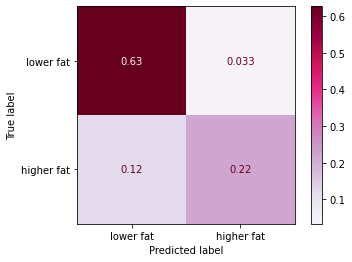

In [30]:
cm_plot = plot_confusion_matrix(depth_search, X_test, y_test, display_labels = ['lower fat','higher fat'],
                      cmap="PuRd", normalize='all')

**Figure 4.** Confusion matrix of the test dataset.

In [31]:
class_report = classification_report(y_test, depth_search.predict(X_test), output_dict=True)
class_report_df = pd.DataFrame(class_report)
class_report_df = class_report_df.rename(columns={"0": "lower fat", "1": "higher fat"})
class_report_df

,lower fat,higher fat,accuracy,macro avg,weighted avg
precision,0.839744,0.867925,0.84689,0.853834,0.849317
recall,0.949275,0.647887,0.84689,0.798581,0.846890
f1-score,0.891156,0.741935,0.84689,0.816546,0.840464
support,138.000000,71.000000,0.84689,209.000000,209.000000


**Table 8.** Classification report for the test dataset.

# Discussion

The data is relatively balanced, so we can report the accuracy score of 0.85. This is an improvement compared to the dummy model which has an accuracy of 0.66, and the SVM accuracy score of 0.80. 

The results from Table 8 indicate that apart from the precision metric, the lower fat category performs better than the higher fat category.

* The precision of the lower fat category is 0.84, and the higher fat category is 0.87.
* The recall of the lower fat category is 0.95 and for the higher fat category it is 0.65. 
* The f1 score of the lower fat category is 0.89 and for the higher fat category it is 0.74.

The highest scoring metric was recall for the lower fat category. This is interesting because it suggests that the number of false negatives is relatively low for this category. 

It is interesting to note that the lower fat category is larger than the higher fat category. This could have some influence on the observed results. To improve the scores, we need to decrease the number of false negatives and false positives, either by oversampling the positive cases, undersampling the negative cases, or weighting the classes differently.

An interesting future exploration of this dataset would be to use the text columns in our analysis, or perform a regresssion analysis. Could we use this dataset to give us a fat percent, instead of a categorical fat level? 

Overall, the results show that this model is able to predict whether a cheese is higher fat or lower fat reasonably well.  

## References

Code from this project was copied with appropriate modifications from completed assignments and modules in this course. 